In [1]:
import numpy as np

import matplotlib.pyplot as plt

import h5py    

import healpy as hp

from astropy.io import fits
from pixell import enmap,utils, reproject, bunch, curvedsky#, enplot

import os

import dill as pk

In [2]:
#Unit conversion courtesy Zach Li

from astropy import units as u
from astropy.constants import k_B, h

def xf(nu):
    return h * nu / k_B / (2.725 * u.K)

def y_to_muK(nu):
    factor = (2.725e6) * (xf(nu) * (np.exp(xf(nu))+1) / np.expm1(xf(nu)) - 4)
    return (factor + 0.).value  # add zero for dimensionless

def Jy_to_muK(nu):
    factor = 1.05e-3 * np.expm1(xf(nu))**2 * np.exp(-xf(nu)) * (nu / (100 * u.GHz))**(-4)
    return (factor + 0.).value


In [3]:
path = "/mnt/welch/USERS/jorlo/maps/websky/"

# Make CMB

In [4]:
shape,wcs = enmap.fullsky_geometry(res = np.deg2rad(0.5/60))

alm = hp.read_alm(path+'lensed_alm.fits',hdu=(1,2,3))
cmb_map = curvedsky.alm2map(alm.astype(np.complex128)[0,:], enmap.empty(shape,wcs,dtype=np.float32))

cmb_map = reproject.thumbnails(cmb_map, [0,0], r=1*utils.degree) #Make a small postage stamp for debugging

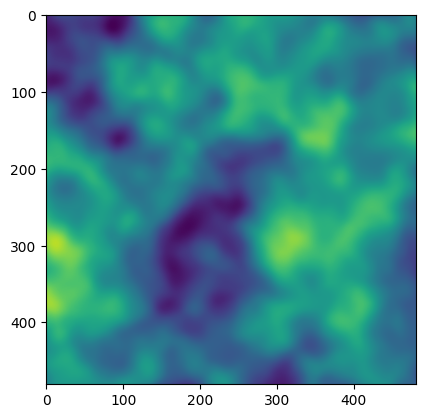

In [5]:
lims = 250

plt.imshow(cmb_map, vmin=-lims, vmax=lims)

# Add tSZ

In [6]:
tsz_map = hp.read_map(path + "tsz_8192.fits")

npix = tsz_map.size # assuming single healpix map
nside = hp.npix2nside(npix)
lmax = 3*nside

tsz_map = reproject.healpix2map(tsz_map, shape = cmb_map.shape, wcs = cmb_map.wcs, lmax = lmax)

#Hard coded conversion factors from Stein20 Websky paper
tsz_093 = -4.2840*1e6
tsz_145 = -2.7685*1e6
tsz_225 =  3.1517*1e5

comb_map = tsz_map*tsz_145+cmb_map

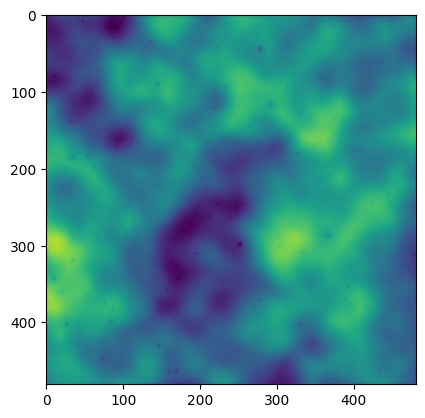

In [7]:
plt.imshow(comb_map, vmin=-lims, vmax=lims)

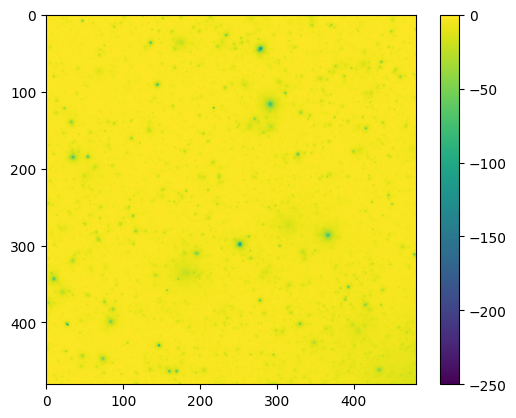

In [8]:
plt.imshow(tsz_map*tsz_145, vmin=-lims, vmax=0)
plt.colorbar()

# Add CIB

In [23]:
cib_map = hp.read_map(path + "cib_nu0217.fits")

cib_map = reproject.healpix2map(cib_map, shape = cmb_map.shape, wcs = cmb_map.wcs, lmax=lmax)

#Hard coded CIB conversions

cib_093 = 4.6831*1e3
cib_145 = 2.5947*1e3
cib_217 = 2.0676*1e3
cib_225 = 2.0716*1e3

comb_map = cib_map*cib_145+comb_map

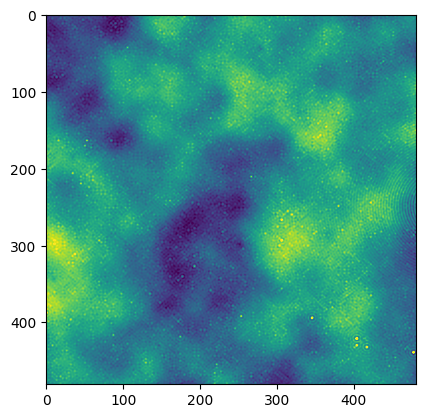

In [10]:
plt.imshow(comb_map, vmin=-lims, vmax=lims)

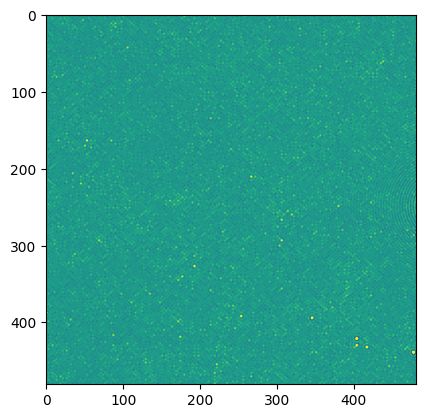

In [20]:
plt.imshow(cib_map*cib_145, vmin=-lims, vmax=lims)

# Add Radio

In [16]:
radio_map = enmap.read_map(path + "/map_radio_0.5arcmin_f143.0.fits")
radio_map = reproject.thumbnails(radio_map, [0,0], r=1*utils.degree) #Make a small postage stamp for debugging

comb_map += radio_map*Jy_to_muK(145 * u.GHz)

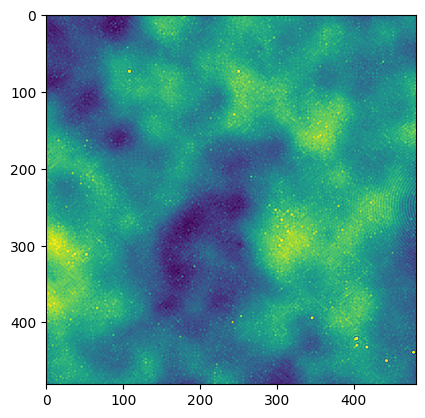

In [18]:
plt.imshow(comb_map, vmin = -lims, vmax=lims)

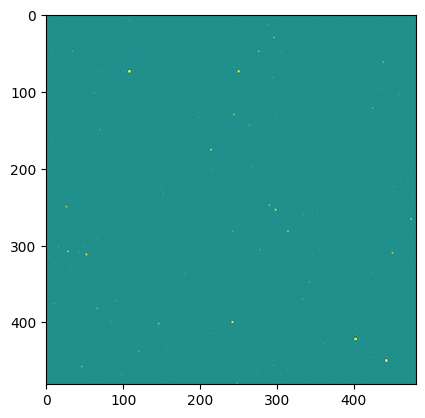

In [22]:
plt.imshow(radio_map*Jy_to_muK(145 * u.GHz), vmin=-lims, vmax=lims)